In [1]:
import os
import json
os.environ['http_proxy'] = 'http://10.10.9.50:3000'
os.environ['https_proxy'] = 'http://10.10.9.50:3000'
os.environ['no_proxy'] = 'localhost,127.0.0.1'

本教程包括以下3个部分:

1. 如何使用 Chat Completion 接口向模型描述外部函数。<br/>
2. 如何与模型交互，触发模型对函数的调用。<br/>
3. 如何使用模型生成的结果调用外部函数。

· tools 是内容生成 API 中的可选参数，用于向模型提供函数定义。<br/>
· 通过此参数，模型能够生成符合用户所提供规范的函数参数。<br/>
· 请注意，API 实际上不会执行任何函数调用，仅返回调用函数所需要的参数。开发者可以利用模型输出的参数在应用中执行函数调用。

## 1. 如何描述外部函数
假设我们要创建一个具备查询航班功能的聊天机器人。我们定义如下两个外部函数供模型选择调用：

· 查询两地之间某日航班号函数：get_flight_number(departure: str, destination: str, date: str)<br/>
· 查询某航班某日票价函数：get_ticket_price(flight_number: str, date: str)

### 1.1 描述函数功能
为了向模型描述外部函数库，需要向 tools 字段传入可以调用的函数列表。参数如下表：

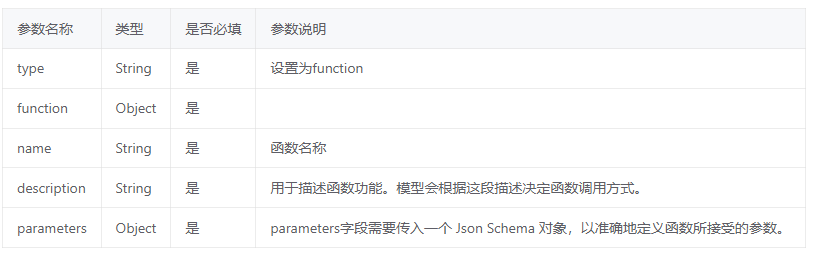


编写函数参数列表的 JSON 描述：<br/>
为了准确定义函数的参数列表，在编写参数列表的 JSON Schema 时建议最少包含以下字段：<br/>

description ：说明函数方法的用途。<br/>
type ：定义 JSON 数据的数据类型约束。<br/>
properties：一个Object，其中的每个属性代表要定义的 JSON 数据中的一个键。<br/>
required：指定哪些属性在数据中必须被包含。<br/>
enum：如果一个属性是枚举类型，则此字段应当设置为枚举值的数组。<br/>

In [2]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_flight_number",
            "description": "根据始发地、目的地和日期，查询对应日期的航班号",
            "parameters": {
                "type": "object",
                "properties": {
                    "departure": {
                        "description": "出发地",
                        "type": "string"
                    },
                    "destination": {
                        "description": "目的地",
                        "type": "string"
                    },
                    "date": {
                        "description": "日期",
                        "type": "string",
                    }
                },
                "required": [ "departure", "destination", "date" ]
            },
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_ticket_price",
            "description": "查询某航班在某日的票价",
            "parameters": {
                "type": "object",
                "properties": {
                    "flight_number": {
                        "description": "航班号",
                        "type": "string"
                    },
                    "date": {
                        "description": "日期",
                        "type": "string",
                    }
                },
                "required": [ "flight_number", "date"]
            },
        }
    },
]

## 2.与模型交互，触发函数调用
函数调用选择<br/>
在 tools 参数中，如果填写了 functions 参数，则默认情况下模型将决定何时适合使用其中一个函数。 如果要控制模型如何选择函数调用，需要设置 tool_choice 参数。参数默认值为auto，此时模型根据上下文信息自行选择是否返回函数调用。还可以通过将 tool_choice 参数设置为 “none” 来强制 API 不返回任何函数的调用。目前函数调用仅支持 auto 模式。

Function Call 流程实践<br/>
本节将以上文定义的具备查询航班功能的聊天机器人为例，介绍如何与模型对话完成函数调用。

初始化函数定义和client：

In [3]:
from zhipuai import ZhipuAI
client = ZhipuAI(api_key="cc28e0d694973a7276d02d6822e5958c.5h0H2TcNId2qBGBi")

### 2.1 我们想查询2024年1月20日从北京前往上海的航班。我们向模型提供这个信息：

In [4]:
messages = []
messages.append({"role": "user", "content": "帮我查询从2024年1月20日，从北京出发前往上海的航班"})
response = client.chat.completions.create(
    model="glm-4",  # 填写需要调用的模型名称
    messages=messages,
    tools=tools,
)
print(response.choices[0].message)
messages.append(response.choices[0].message.model_dump())

CompletionMessage(content=None, role='assistant', tool_calls=[CompletionMessageToolCall(id='call_9106862906070347132', function=Function(arguments='{"date":"2024-01-20","departure":"北京","destination":"上海"}', name='get_flight_number'), type='function', index=0)])


### 可以看到，此时模型成功触发对get_flight_number函数的调用，参数为：date=“2024-01-20”,departure=“北京”,destination=“上海”

### 2.2 现在，清空消息历史。我们尝试提供信息，触发模型对get_ticket_price函数的调用。

In [5]:
messages = []
messages.append({"role": "system", "content": "不要假设或猜测传入函数的参数值。如果用户的描述不明确，请要求用户提供必要信息"})
messages.append({"role": "user", "content": "帮我查询2024年1月20日1234航班的票价"})
response = client.chat.completions.create(
    model="glm-4",  # 填写需要调用的模型名称
    messages=messages,
    tools=tools,
)
print(response.choices[0].message)
messages.append(response.choices[0].message.model_dump())

CompletionMessage(content=None, role='assistant', tool_calls=[CompletionMessageToolCall(id='call_9106862974789889531', function=Function(arguments='{"date":"2024-01-20","flight_number":"1234"}', name='get_ticket_price'), type='function', index=0)])


### 2.3 我们也可以强制模型使用特定函数
比如，我们通过设置tool_choice为{“type”: “function”, “function”: {“name”: “get_ticket_price”}}以强制模型生成调用get_ticket_price的参数。<br/>
我们也可以强制模型不调用函数。需要设置tool_choice为none。

In [6]:
messages = []
messages.append({"role": "system", "content": "不要假设或猜测传入函数的参数值。如果用户的描述不明确，请要求用户提供必要信息"})
messages.append({"role": "user", "content": "帮我查询1234航班的票价"})
response = client.chat.completions.create(
    model="glm-4",  # 填写需要调用的模型名称
    messages=messages,
    tools=tools,
    tool_choice={"type": "function", "function": {"name": "get_ticket_price"}},
)
print(response.choices[0].message)
messages.append(response.choices[0].message.model_dump())

CompletionMessage(content=None, role='assistant', tool_calls=[CompletionMessageToolCall(id='call_9106867063600082356', function=Function(arguments='{"date":"2021-06-01","flight_number":"1234"}', name='get_ticket_price'), type='function', index=0)])


## 3. 使用模型生成的参数调用函数

### 3.1 将所需要的函数实现

In [7]:
def get_flight_number(date:str , departure:str , destination:str):
    flight_number = {
        "北京":{
            "上海" : "1234",
            "广州" : "8321",
        },
        "上海":{
            "北京" : "1233",
            "广州" : "8123",
        }
    }
    return { "flight_number":flight_number[departure][destination] }
def get_ticket_price(date:str , flight_number:str):
    return {"ticket_price": "1000"}

### 3.2 定义处理 Function call 的函数：

In [8]:
def parse_function_call(model_response,messages):
    # 处理函数调用结果，根据模型返回参数，调用对应的函数。
    # 调用函数返回结果后构造tool message，再次调用模型，将函数结果输入模型
    # 模型会将函数调用结果以自然语言格式返回给用户。
    if model_response.choices[0].message.tool_calls:
        tool_call = model_response.choices[0].message.tool_calls[0]
        args = tool_call.function.arguments
        function_result = {}
        if tool_call.function.name == "get_flight_number":
            function_result = get_flight_number(**json.loads(args))
        if tool_call.function.name == "get_ticket_price":
            function_result = get_ticket_price(**json.loads(args))
        messages.append({
            "role": "tool",
            "content": f"{json.dumps(function_result)}",
            "tool_call_id":tool_call.id
        })
        response = client.chat.completions.create(
            model="glm-4",  # 填写需要调用的模型名称
            messages=messages,
            tools=tools,
        )
        print(response.choices[0].message)
        messages.append(response.choices[0].message.model_dump())

### 3.3 查询北京到广州的航班：

In [9]:
# 清空对话
messages = []
 
messages.append({"role": "system", "content": "不要假设或猜测传入函数的参数值。如果用户的描述不明确，请要求用户提供必要信息"})
messages.append({"role": "user", "content": "帮我查询1月23日，北京到广州的航班"})
 
response = client.chat.completions.create(
    model="glm-4",  # 填写需要调用的模型名称
    messages=messages,
    tools=tools,
)
print(response.choices[0].message)
messages.append(response.choices[0].message.model_dump())
 
parse_function_call(response,messages)

CompletionMessage(content=None, role='assistant', tool_calls=[CompletionMessageToolCall(id='call_9106862837350813170', function=Function(arguments='{"date":"2022-01-23","departure":"北京","destination":"广州"}', name='get_flight_number'), type='function', index=0)])
CompletionMessage(content='根据您的请求，我已经查询到1月23日从北京到广州的航班号是8321。', role='assistant', tool_calls=None)


### 3.4 查询1234航班票价：

In [10]:
messages.append({"role": "user", "content": "这趟航班的价格是多少？"})
response = client.chat.completions.create(
    model="glm-4",  # 填写需要调用的模型名称
    messages=messages,
    tools=tools,
)
print(response.choices[0].message)
messages.append(response.choices[0].message.model_dump())
 
parse_function_call(response,messages)

CompletionMessage(content=None, role='assistant', tool_calls=[CompletionMessageToolCall(id='call_9106862528112856677', function=Function(arguments='{"date":"2022-01-23","flight_number":"8321"}', name='get_ticket_price'), type='function', index=0)])
CompletionMessage(content='这趟航班的价格是1000元。', role='assistant', tool_calls=None)
